In [1]:
from glob import glob
import json
import pandas as pd
from tqdm import tqdm
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "../.."
dataset = "1100"

In [2]:
jsons = glob(f"{path}/seqfiles_{dataset}/*/seq.json")

In [3]:
jsons

['../../seqfiles_1100/first_STRAIN-EFFECT_PRESENTS_enhanced_biofilm_formation/seq.json',
 '../../seqfiles_1100/first_STRAIN-MEDIUM_GROWS_ON_lba/seq.json',
 '../../seqfiles_1100/first_COMPOUND-STRAIN_INHIBITS_a1p/seq.json',
 '../../seqfiles_1100/first_STRAIN-PHENOTYPE_PRESENTS_micro/seq.json',
 '../../seqfiles_1100/first_STRAIN-COMPOUND_PRODUCES_ta/seq.json',
 '../../seqfiles_1100/first_COMPOUND-STRAIN_INHIBITS_eh/seq.json',
 '../../seqfiles_1100/first_STRAIN-MEDIUM_GROWS_ON_sbm/seq.json',
 '../../seqfiles_1100/first_STRAIN-COMPOUND_PRODUCES_nisin/seq.json',
 '../../seqfiles_1100/first_STRAIN-MEDIUM_GROWS_ON_starch_agar/seq.json',
 '../../seqfiles_1100/first_STRAIN-ORGANISM_INHABITS_a._thaliana/seq.json',
 '../../seqfiles_1100/first_STRAIN-DISEASE_INHIBITS_colon_adenocarcinoma/seq.json',
 '../../seqfiles_1100/first_COMPOUND-STRAIN_INHIBITS_nisin_h/seq.json',
 '../../seqfiles_1100/first_STRAIN-MEDIUM_GROWS_ON_wheat_bran/seq.json',
 '../../seqfiles_1100/first_STRAIN-COMPOUND_PRODUCES_meso

In [4]:
data = []
for json_file in tqdm(jsons, desc="Processing JSON files"):
    folder_name = os.path.basename(os.path.dirname(json_file))
    try:
        with open(json_file) as f:
            json_data = json.load(f)
            p_value = json_data["test results"]["p-value"]
            lrt = json_data["test results"]["LRT"]
            data.append({'name': folder_name, 'p_value': p_value, 'lrt': lrt})
    except json.JSONDecodeError:
        continue

evolution = pd.DataFrame(data)


Processing JSON files: 100%|██████████| 730/730 [01:36<00:00,  7.58it/s]


In [5]:
evolution

,name,p_value,lrt
0,first_STRAIN-EFFECT_PRESENTS_enhanced_biofilm_...,0.024626,6.021646
1,first_STRAIN-MEDIUM_GROWS_ON_lba,0.000093,17.178557
2,first_COMPOUND-STRAIN_INHIBITS_a1p,0.500000,0.000000
3,first_STRAIN-PHENOTYPE_PRESENTS_micro,0.308658,0.964748
4,first_STRAIN-COMPOUND_PRODUCES_ta,0.500000,0.000000
...,...,...,...
715,first_STRAIN-COMPOUND_RESISTS_nitrofurantoin,0.246732,1.412613
716,first_COMPOUND-STRAIN_INHIBITS_octanoic_acid,0.500000,0.000000
717,first_STRAIN-MEDIUM_GROWS_ON_tryptic_soy,0.000002,25.307294
718,first_COMPOUND-STRAIN_INHIBITS_glutaraldehyde,0.069254,3.953643


In [33]:
evolution["name"] = evolution["name"].str.replace("_ASSOCIATED_WITH", ":ASSOCIATEDWITH")
evolution["name"] = evolution["name"].str.replace("_GROWS_ON", ":GROWSON")
evolution["name"] = evolution["name"].str.replace("_INHIBITS", ":INHIBITS")
evolution["name"] = evolution["name"].str.replace("_INHABITS", ":INHABITS")
evolution["name"] = evolution["name"].str.replace("_INFECTS", ":INFECTS")
evolution["name"] = evolution["name"].str.replace("_PRESENTS", ":PRESENTS")
evolution["name"] = evolution["name"].str.replace("_DEGRADES", ":DEGRADES")
evolution["name"] = evolution["name"].str.replace("_PRODUCES", ":PRODUCES")
evolution["name"] = evolution["name"].str.replace("_PROMOTES", ":PROMOTES")
evolution["name"] = evolution["name"].str.replace("_RESISTS", ":RESISTS")
evolution

,name,p_value,lrt,gene,rel,ner
0,first_STRAIN-EFFECT:PRESENTS_enhanced_biofilm_...,0.024626,6.021646,first,STRAIN-EFFECT:PRESENTS,enhanced_biofilm_formation
1,first_STRAIN-MEDIUM:GROWSON_lba,0.000093,17.178557,first,STRAIN-MEDIUM:GROWS_ON,lba
2,first_COMPOUND-STRAIN:INHIBITS_a1p,0.500000,0.000000,first,COMPOUND-STRAIN:INHIBITS,a1p
3,first_STRAIN-PHENOTYPE:PRESENTS_micro,0.308658,0.964748,first,STRAIN-PHENOTYPE:PRESENTS,micro
4,first_STRAIN-COMPOUND:PRODUCES_ta,0.500000,0.000000,first,STRAIN-COMPOUND:PRODUCES,ta
...,...,...,...,...,...,...
715,first_STRAIN-COMPOUND:RESISTS_nitrofurantoin,0.246732,1.412613,first,STRAIN-COMPOUND,RESISTS_nitrofurantoin
716,first_COMPOUND-STRAIN:INHIBITS_octanoic_acid,0.500000,0.000000,first,COMPOUND-STRAIN:INHIBITS,octanoic_acid
717,first_STRAIN-MEDIUM:GROWSON_tryptic_soy,0.000002,25.307294,first,STRAIN-MEDIUM:GROWS_ON,tryptic_soy
718,first_COMPOUND-STRAIN:INHIBITS_glutaraldehyde,0.069254,3.953643,first,COMPOUND-STRAIN:INHIBITS,glutaraldehyde


In [34]:
evolution["gene"] = evolution.name.str.split("_",expand=True,n=2)[0]
evolution["rel"] = evolution.name.str.split("_",expand=True,n=2)[1]
evolution["ner"] = evolution.name.str.split("_",expand=True,n=2)[2]

In [35]:
evolution["rel"] = evolution["rel"].str.replace("ASSOCIATEDWITH","ASSOCIATED_WITH")
evolution["rel"] = evolution["rel"].str.replace("GROWSON","GROWS_ON")

In [44]:
with open(f"{path}/xgboost/annotations{dataset}/binary.pkl", 'rb') as f:
#with open(f"{path}/binary.pkl", 'rb') as f:
	d = pickle.load(f)
rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"{path}/xgboost/annotations{dataset}/*.parquet")]
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			importance_values = s.sort_values(ascending=False).values
			genes = s.sort_values(ascending=False).index.to_list()
			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
			accuracy = d[rel][i][1]
			ner = d[rel][i][0][0]
			for j in range(len(importance_values)):
				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy])
df = pd.DataFrame(l, columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

100%|██████████| 17/17 [01:01<00:00,  3.64s/it]


In [45]:
df.to_csv("evolution.csv")

In [41]:
df.value_counts("rel")

rel
COMPOUND-STRAIN:INHIBITS          2316
STRAIN-COMPOUND:PRODUCES          2088
STRAIN-MEDIUM:GROWS_ON            1742
STRAIN-PHENOTYPE:PRESENTS         1082
STRAIN-EFFECT:PRESENTS             779
STRAIN-EFFECT:PROMOTES             621
STRAIN-COMPOUND:RESISTS            489
STRAIN-DISEASE:INHIBITS            408
STRAIN-ORGANISM:INFECTS            374
STRAIN-ORGANISM:INHABITS           294
STRAIN-COMPOUND:DEGRADES           180
STRAIN-ORGANISM:INHIBITS           165
STRAIN-ISOLATE:INHABITS            158
STRAIN-DISEASE:ASSOCIATED_WITH     131
STRAIN-SPECIES:INHIBITS             81
STRAIN-ORGANISM:SYMBIONT_OF         49
STRAIN-EFFECT:INHIBITS              13
Name: count, dtype: int64

In [15]:
df["ner"] = df.ner.str.replace(' ','_').str.replace("'",'').str.replace('(','_').str.replace(')','_')

In [16]:
df = df[df["importance_ranking"]==1]

In [17]:
all_merged = df.merge(evolution, on=["ner","rel"]).drop(columns="gene_y")

In [18]:
all_merged.sort_values("lrt",ascending=False).to_csv("positive_selection.csv",index=False)

In [19]:
all_merged

,rel,ner,gene_x,importance_values,importance_ranking,accuracy,name,p_value,lrt
0,STRAIN-DISEASE:ASSOCIATED_WITH,acquired_infections,"Uncharacterised protein family, inner membrane...",57.046097,1.0,0.989362,first_STRAIN-DISEASE:ASSOCIATEDWITH_acquired_i...,1.311617e-12,53.333195
1,STRAIN-SPECIES:INHIBITS,p._aeruginosa,"Bacteriophage T4, Gp38, tail fibre assembly",17.940186,1.0,0.960754,first_STRAIN-SPECIES:INHIBITS_p._aeruginosa,5.000000e-01,0.000000
2,STRAIN-SPECIES:INHIBITS,albicans,RICH domain,339.392090,1.0,0.993721,first_STRAIN-SPECIES:INHIBITS_albicans,4.197416e-01,0.349938
3,STRAIN-SPECIES:INHIBITS,.,"Bacteriophage SP-beta, YorD",11.460204,1.0,0.970173,first_STRAIN-SPECIES:INHIBITS_.,2.250765e-01,1.596336
4,STRAIN-SPECIES:INHIBITS,l._plantarum,"Bacteriophage tail tape measure, C-terminal",5.187326,1.0,0.985871,first_STRAIN-SPECIES:INHIBITS_l._plantarum,4.186215e-01,0.355282
...,...,...,...,...,...,...,...,...,...
671,STRAIN-MEDIUM:GROWS_ON,spizizens_minimal,"Protein of unknown function, YrpD",9.406350,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_spizizens_minimal,3.778219e-01,0.560371
672,STRAIN-MEDIUM:GROWS_ON,sterile_bhi_broth,"Outer membrane porin, bacterial",5.357529,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_sterile_bhi_broth,4.047856e-07,28.053522
673,STRAIN-MEDIUM:GROWS_ON,wxml,"Protein of unknown function, YrpD",6.853095,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_wxml,5.000000e-01,0.000000
674,STRAIN-MEDIUM:GROWS_ON,modified,Large-conductance mechanosensitive channel/and...,3.153642,1.0,0.999739,first_STRAIN-MEDIUM:GROWSON_modified,5.000000e-01,0.000000


In [20]:
all_merged["-log10(p_value)"] = -1 * all_merged["p_value"].apply(np.log10)
all_merged["logLRT"] = all_merged["lrt"].apply(np.log10)
all_merged["log_imp"] = all_merged["importance_values"].apply(np.log10)

In [43]:
all_merged

,rel,ner,gene_x,importance_values,importance_ranking,accuracy,name,p_value,lrt,-log10(p_value),logLRT,log_imp
0,STRAIN-DISEASE:ASSOCIATED_WITH,acquired_infections,"Uncharacterised protein family, inner membrane...",57.046097,1.0,0.989362,first_STRAIN-DISEASE:ASSOCIATEDWITH_acquired_i...,1.311617e-12,53.333195,11.882193,1.726998,1.756226
1,STRAIN-SPECIES:INHIBITS,p._aeruginosa,"Bacteriophage T4, Gp38, tail fibre assembly",17.940186,1.0,0.960754,first_STRAIN-SPECIES:INHIBITS_p._aeruginosa,5.000000e-01,0.000000,0.301030,-inf,1.253827
2,STRAIN-SPECIES:INHIBITS,albicans,RICH domain,339.392090,1.0,0.993721,first_STRAIN-SPECIES:INHIBITS_albicans,4.197416e-01,0.349938,0.377018,-0.456009,2.530702
3,STRAIN-SPECIES:INHIBITS,.,"Bacteriophage SP-beta, YorD",11.460204,1.0,0.970173,first_STRAIN-SPECIES:INHIBITS_.,2.250765e-01,1.596336,0.647670,0.203124,1.059192
4,STRAIN-SPECIES:INHIBITS,l._plantarum,"Bacteriophage tail tape measure, C-terminal",5.187326,1.0,0.985871,first_STRAIN-SPECIES:INHIBITS_l._plantarum,4.186215e-01,0.355282,0.378178,-0.449427,0.714944
...,...,...,...,...,...,...,...,...,...,...,...,...
671,STRAIN-MEDIUM:GROWS_ON,spizizens_minimal,"Protein of unknown function, YrpD",9.406350,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_spizizens_minimal,3.778219e-01,0.560371,0.422713,-0.251525,0.973421
672,STRAIN-MEDIUM:GROWS_ON,sterile_bhi_broth,"Outer membrane porin, bacterial",5.357529,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_sterile_bhi_broth,4.047856e-07,28.053522,6.392775,1.447987,0.728965
673,STRAIN-MEDIUM:GROWS_ON,wxml,"Protein of unknown function, YrpD",6.853095,1.0,0.999791,first_STRAIN-MEDIUM:GROWSON_wxml,5.000000e-01,0.000000,0.301030,-inf,0.835887
674,STRAIN-MEDIUM:GROWS_ON,modified,Large-conductance mechanosensitive channel/and...,3.153642,1.0,0.999739,first_STRAIN-MEDIUM:GROWSON_modified,5.000000e-01,0.000000,0.301030,-inf,0.498812


Text(0.5, 1.0, 'Linear Regression')

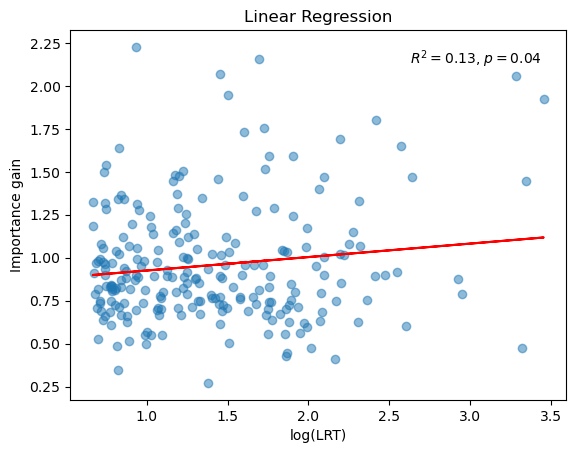

In [21]:
from scipy.stats import linregress
# Define the x and y values, filtering out np.nan values
x = all_merged[all_merged.p_value < 0.05]['logLRT'].dropna()
y = all_merged[all_merged.p_value < 0.05]['log_imp'].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the linear regression line
line = slope * x + intercept

# Plot the data points and linear regression line
plt.scatter(x, y, alpha=0.5)
plt.plot(x, line, color='red')

# Add the R^2 value as text on the side
plt.text(0.95, 0.95, f'$R^2 = ${r_value:.2f}, $p=${p_value:.2f}', ha='right', va='top', transform=plt.gca().transAxes)

# Set the labels and title
plt.xlabel('log(LRT)')
plt.ylabel('Importance gain')
plt.title('Linear Regression')


In [22]:
linregress(x, y)

LinregressResult(slope=np.float64(0.07814045918170254), intercept=np.float64(0.8477937658965644), rvalue=np.float64(0.1343225363891135), pvalue=np.float64(0.04006777162490288), stderr=np.float64(0.03784682209269976), intercept_stderr=np.float64(0.057086720003985375))

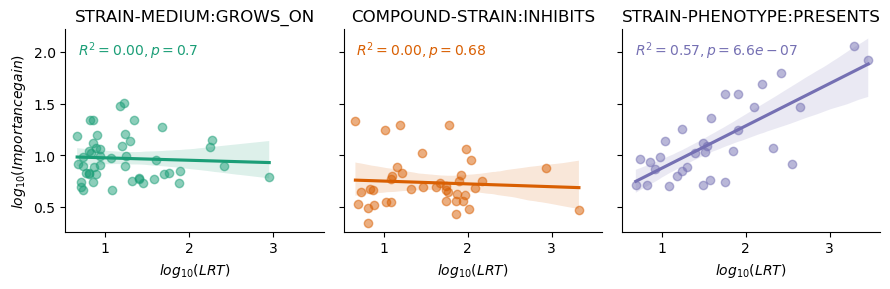

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set the color palette to the accent color set
sns.set_palette("Dark2")

# Define the desired order for 'rel' categories
category_order = [
    "STRAIN-MEDIUM:GROWS_ON",
    "COMPOUND-STRAIN:INHIBITS",
    "STRAIN-PHENOTYPE:PRESENTS"
]

# Filter the dataset as per your conditions
filtered_data = all_merged[
    (all_merged.p_value < 0.05) & 
    (all_merged.rel.isin(category_order))
]

# Initialize a dictionary to store regression results
regression_results = {}

# Calculate regression statistics for each 'rel' subset after removing infinite values
for rel in category_order:
    subset = filtered_data[filtered_data['rel'] == rel]
    
    # Remove rows with infinite values in 'logLRT' or 'log_imp'
    subset_clean = subset[np.isfinite(subset['logLRT']) & np.isfinite(subset['log_imp'])]
    
    if not subset_clean.empty:  # Only calculate if there's valid data
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(subset_clean['logLRT'], subset_clean['log_imp'])
        
        # Store results in the dictionary
        regression_results[rel] = {
            'r_squared': r_value ** 2,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept
        }
    else:
        # Store None if the subset is empty after filtering
        regression_results[rel] = None

# Your code for plotting the dataframe
g = sns.lmplot(
    x="logLRT", 
    y="log_imp", 
    col="rel", 
    hue="rel", 
    data=filtered_data, 
    aspect=1, 
    height=3, 
    scatter_kws={"alpha": 0.5},
    col_order=category_order,  # Set column order
    hue_order=category_order   # Set hue order
)

g.set_axis_labels("$log_{10}(LRT)$", "$log_{10}(Importance gain)$")

# Add text annotations for each subplot and set titles
for ax, rel in zip(g.axes.flat, category_order):
    results = regression_results[rel]
    
    if results is not None:  # Only add text if there were valid results
        # Get the color used for the line plot
        line_color = ax.get_lines()[0].get_color()
        
        # Add text annotations for R-squared and p-value
        ax.text(
            0.05, 0.95,  # X and Y positions (in axis units)
            f'$R^2 = {results["r_squared"]:.2f}, p = {results["p_value"]:.2g}$',
            transform=ax.transAxes,  # Use axis coordinates for positioning
            verticalalignment='top',  # Align text at the top
            color=line_color  # Use the same color as the line
        )

    # Set the title of each subplot to just the value of 'rel'
    ax.set_title(rel)

plt.tight_layout()
plt.savefig("figures/xgboost/positive_selection_latest.pdf", bbox_inches="tight")
plt.show()

In [27]:
linregress(subset_clean['logLRT'], subset_clean['log_imp'])

LinregressResult(slope=np.float64(0.41095466593860686), intercept=np.float64(0.46179335922708453), rvalue=np.float64(0.7529353617711263), pvalue=np.float64(6.634459825887731e-07), stderr=np.float64(0.06557885659725131), intercept_stderr=np.float64(0.11727684802553742))